# Hyperparameter Selection and Visualization

In this notebook I will be covering hyperparameter selection for model tuning.   Hyperparameters express “higher-level” properties of the model such as its complexity or how fast it should learn.  Hyperparameters are usually fixed before the actual training process begins, and cannot be learned directly from the data in the standard model training process. Model developers will predefine these hyperparameters by testing different values, training different models, and choosing the values that test better.

Examples of hyperparmeters are:
- number of leaves in a tree based model
- clusters in a k-means algorithm
- number of hidden layers in a neural network
- penalization incurred by additional model complexity
- learning rate 

In this notebook I will do hyperparameter selection for a model, including visualization of the hyperparameter grid as well as a revision after seeing unintuitive results.

In [77]:
#Image displat packages
from IPython.display import Image
from IPython.core.display import HTML 

#Loading Necessary Background Packages
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load data
iris = datasets.load_iris()
X = iris.data 
y = iris.target

### Hyperparameter Optimization 

We'll be using cross validation to initially find the optimal hyperparameters for our SVM kernal classifier.  

When training our SVM clasisifier with the Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma.  Proper choice of these two hyperparameters is critical to the SVM classifier's performance.  We use cross validation and a separate train/test set because we do not want to overfit our hyperparamters to our data.  Hence we will be finding the parameters on a separate dataset than the dataset we will be evaluating our model on.

The parameter C, common to a lot of ML algorithms, trades off misclassiciation for simpliciity.  A low C will make the decision boundary smooth (trading off some accuracy), while a high C will trade off high accuracy for simplicity.  See below for an example of this in action.

In [5]:
Image(url= "https://www.analyticsvidhya.com/wp-content/uploads/2015/10/SVM_18.png")

Gamma defines how much influence a single training example has. Consider it a 'sphere of influence'. The larger gamma is, the closer other examples must be to be affected.

In [6]:
Image(url= "https://www.analyticsvidhya.com/wp-content/uploads/2015/10/SVM_15.png")

We will be splitting our data into testing and training datasets, like we did before.  We will be finding the our optimal hyperparameters on the training dataset before we evaluate them on our training set.

In [7]:
# split into test and train
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=False)

In [10]:
# load in SVC - a kernel classifier function from the scikit-learn library
from sklearn.svm import SVC

# create a default instance of the classifier
classifier = SVC()

I will create a dictionary of possible gammas and C's for our cross validator to run through.  I looked through literature and examples of the SVM rbf kernel to get a sense of what others were using.  For an initial search, a logarithmic grid with basis 10 is used. 

In [49]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)

I will be using the GridSearchCV package to run hyperparameter cross validation on the training dataset.

GridSearchCV's default settings will run 3-fold cross validation, but I will be doing 5-fold cross validation.

In [50]:
# import cross validation packages
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

# setup 5 fold cross validation to be fed into the GridSearchCV package
cv_5 = KFold(5)

In [78]:
# create a parameter range to test over
parameters = {'kernel':['rbf'], 'gamma':gamma_range, 'C':C_range}

# create an instance of the GridSearchCV cross-validator - using our classifier 
# and choice or parameters
cross_validator = GridSearchCV(classifier, parameters, cv=cv_5)

In [79]:
# fit the data
cross_validator.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf'], 'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10]), 'gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [80]:
best_gamma = cross_validator.best_estimator_.gamma  
best_C = cross_validator.best_estimator_.C

print 'Best Gamma: {}, Best C: {}' .format(best_gamma, best_C)

Best Gamma: 1e-07, Best C: 100000000.0


## Debrief

So from what I've seen in my previous work, the high C initially gave me some concern.  Its not exactly the perfect interpretation, but the C value of 100000000 is essentially stating that our model is weighting misclassifications as being 10\*10^8 times worse than adding complexity to our model.  Its suggesting a C this high because it appears that across all 5 folds of our CV, the high C model was performing very well.  

In a pure out of sample evaluation, our model would likely perform very poorly. My hypothesis why the C is so high is that due to the small testing data set of each k-fold cross validation (only 24 points!) our model is fitting close to all the points in each testing set.

I'll first re-shape the score array such that I can easily access the score of each hyperparamter combination.

In [66]:
scores = cross_validator.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

Checking the 'optimal' hyperparameters, we see that our model was near perfect in its predictions across the testing sets in the 5 folds.

In [65]:
scores[[C_range==100000000, gamma_range==1e-07]]

array([ 0.96666667])

I found a plotting function online that would show me a heatmap of how well the scoring was across each unique hyperparameter combination.

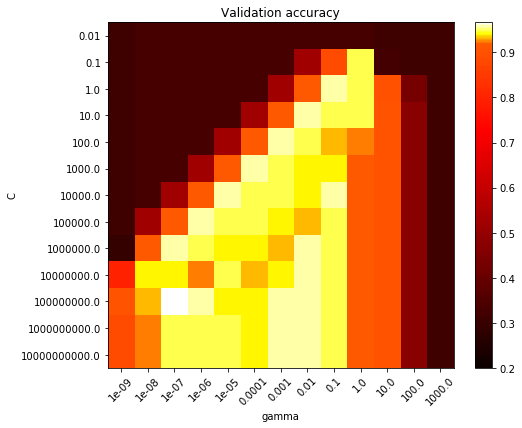

In [67]:
# source: http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

# Utility function to move the midpoint of a colormap to be around
# the values of interest.
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

## Plotting Function
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

Our glowing hot point near the bottom left shows that the particular hyperparameter combo did slightly better than a lot of (already pretty good!) hyperparameter combinations.

To control for this overfitting, I'm going to re-run our hyperparameter grid search using fewer k-folds (To create larger test sets) in addition to some fold shuffling.

In [70]:
cv_3 = StratifiedShuffleSplit(n_splits=3, test_size=0.33, random_state=42)

# create a parameter range to test over
parameters = {'kernel':['rbf'], 'gamma':gamma_range, 'C':C_range}

# create an instance of the GridSearchCV cross-validator - using our classifier and choice or parameters
cross_validator = GridSearchCV(classifier, parameters, cv=cv_4)

# fit the data
cross_validator.fit(X_train, y_train)

best_gamma = cross_validator.best_estimator_.gamma  
best_C = cross_validator.best_estimator_.C

print 'Best Gamma: {}, Best C: {}' .format(best_gamma, best_C)

Best Gamma: 0.01, Best C: 10.0


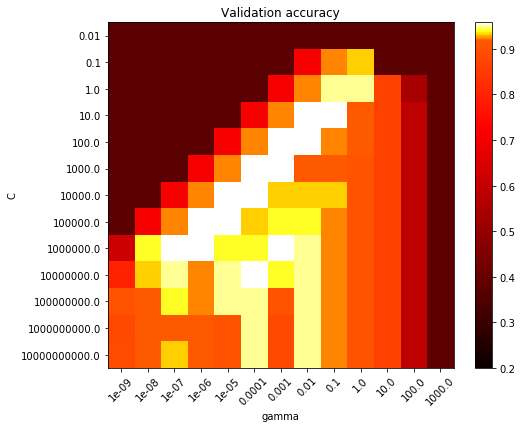

In [71]:
scores = cross_validator.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

White hot! Looks like we didn't lose predictive ability by decreasing the number of folds in our cross validation. We have many good possible C or Gamma values for measuing our model performance.

Now we'll see how our model runs on our testing data with our selected gamma and C.

In [76]:
# Run on test data
cross_validator.score(X_test, y_test)

1.0

Boom! Too good.  If we had other competing models, we'd be comparing this score. Iris is an easy dataset, so this is nothing too groundbreaking to be proud of ;)  